# DeepBNN

# Libraries

In [1]:
!pip install torchmetrics
!pip install skorch
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 4.1 MB/s 


In [3]:
import numpy as np
import random
import time
import scipy

import matplotlib.pyplot as plt
import seaborn as sn
from   tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from   torch.utils.data import Dataset, DataLoader, random_split
from   torch.utils.data.sampler import SubsetRandomSampler 
import torch.nn.functional as FF

import torchvision
from   torchvision import transforms

from   sklearn.metrics import confusion_matrix

import skorch
from   skorch import NeuralNetClassifier
from   skorch.dataset import ValidSplit

from   torchattacks import *
from   scipy.special import expit

# Dataset

In [4]:
#Import MNIST dataset
data_dir = 'dataset'
transform = transforms.Compose([transforms.ToTensor()]) 
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transform)
train_dataset = torchvision.datasets.MNIST(data_dir, train=True,  download=True, transform=transform)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = 10000
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 1
random_seed = 42
train_dataloader      = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False)
validation_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, shuffle=False)
test_dataloader       = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



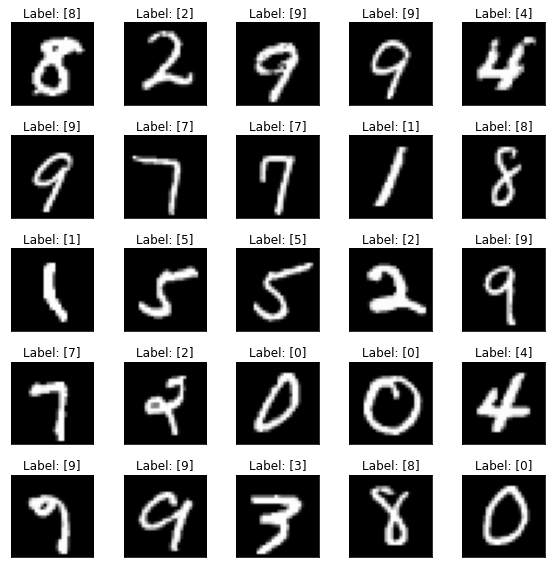

In [5]:
#plot some random images
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
  
    img, label = random.choice(train_dataset) 
    ax.imshow(torch.squeeze(img), cmap='gist_gray')

    ax.set_title(f'Label: [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

SAMPLE AT INDEX 8000
LABEL: 0


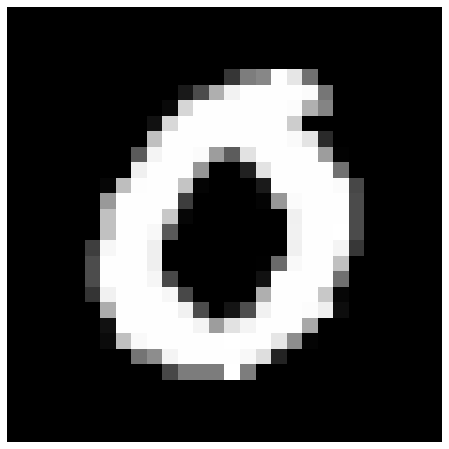

In [6]:
#function for plotting image
def plot_sample(sample_index, train):
  if train == 1:
    image = train_dataset[sample_index][0]
    label = train_dataset[sample_index][1]
  elif train == 0:
    image = test_dataset[sample_index][0]
    label = test_dataset[sample_index][1]

  fig = plt.figure(figsize=(8,8)) 
  plt.imshow(torch.squeeze(image),cmap="Greys_r")
  plt.axis('off')
  print(f"SAMPLE AT INDEX {sample_index}")
  print(f"LABEL: {label}")

sample_index = 8000
image = train_dataset[sample_index][0] #example image
plot_sample(sample_index,1)

# Krotov and Hopfield's Algorithm

## First Phase (First Layer)

In [7]:
#ANN architecture 
neurons_input = image.shape[1]**2
neurons_hidden = 484  
num_classes = 10

n_synapsis = neurons_input*neurons_hidden

### 1° Step: $h$ - ODE

In [8]:
Im = np.ones(neurons_hidden) - np.identity(neurons_hidden) #useful matrix

#---Solution 1° ODE---
def hsteady(h_steady, I_s):
  h = np.zeros((neurons_hidden,lt))
  h[:,0] = h_steady
  dt1_tau = dt1/tau_r
  dt2_tau = dt2/tau_r
  for i in range(1,lt1):
    S = np.matmul( Im, np.maximum(h[:,i-1], 0) )
    h[:,i] = h[:,i-1]*(1-dt1_tau) + ( I_s - winh*S)*dt1_tau

  for i in range(lt1,lt2+lt1):
    S = np.matmul( Im, np.maximum(h[:,i-1], 0) )
    h[:,i] = h[:,i-1]*(1-dt2_tau) + ( I_s - winh*S)*dt2_tau
              
  return h[:,-1] , h

#---Solution 1° ODE---
def hsteady_quick(hnew, I_s):
  dt1_tau = dt1/tau_r
  dt2_tau = dt2/tau_r
  for i in range(1,lt1):
    S = np.matmul( Im, np.maximum(hnew, 0) )
    hnew = hnew*(1-dt1_tau) + ( I_s - winh*S)*dt1_tau

  for i in range(1,lt2):
    S = np.matmul( Im, np.maximum(hnew, 0) )
    hnew = hnew*(1-dt2_tau) + ( I_s - winh*S)*dt2_tau
           
  return hnew

In [9]:
#---Parameters 1° ODE---
tau_r    = 0.01

#--1° part
tmax1  = 0.1
dt1    = 0.0001
t1     = np.arange(0,tmax1,dt1)/tau_r
lt1    = len(t1)

#--2° part
tmax2 = 0.3
dt2   = 0.001
t2    = np.arange(tmax1,tmax2,dt2)/tau_r
lt2   = len(t2)

tt=np.concatenate([t1, t2])
lt=len(tt)

winh   = 1.1
h_star = 5

np.random.seed(2347)
h_steady = np.zeros(neurons_hidden)
sigma = 0.2
W = sigma*np.random.rand( neurons_hidden, neurons_input) #gaussian initialization
v = torch.flatten(image).unsqueeze(dim=1).numpy()
I = np.matmul(W,v)

t = time.time()
h_steady, h = hsteady(h_steady, np.squeeze(I))
print('1° ODE solved in: ',np.round(time.time() - t,3),'s')

frac_pos = np.sum(h_steady>0)/neurons_hidden
print('Winh give positive fraction of:',np.round(frac_pos*100,2),'%')

1° ODE solved in:  0.452 s
Winh give positive fraction of: 0.21 %


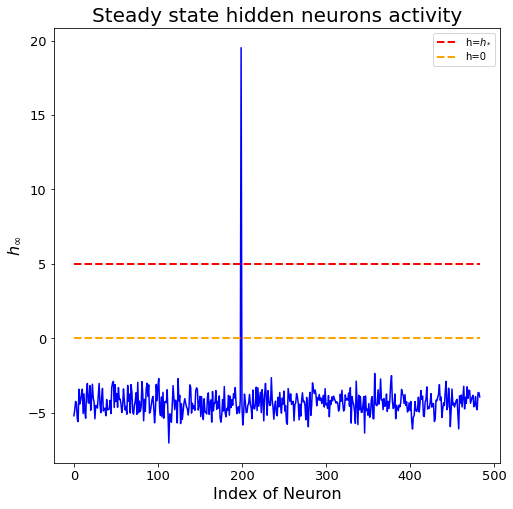

In [10]:
#---Plot post-synaptic steady state activations ---
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(neurons_hidden), h_steady,'b')
plt.plot(np.arange(neurons_hidden), np.ones(neurons_hidden)*h_star,'r--',label='h=$h_{*}$',linewidth=2)
plt.plot(np.arange(neurons_hidden), np.zeros(neurons_hidden),'orange',linestyle='--', label='h=0',linewidth=2)
plt.title('Steady state hidden neurons activity',fontsize=20)
plt.xlabel('Index of Neuron',fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('$h_{\infty}$',fontsize=16)
plt.legend()
plt.show()

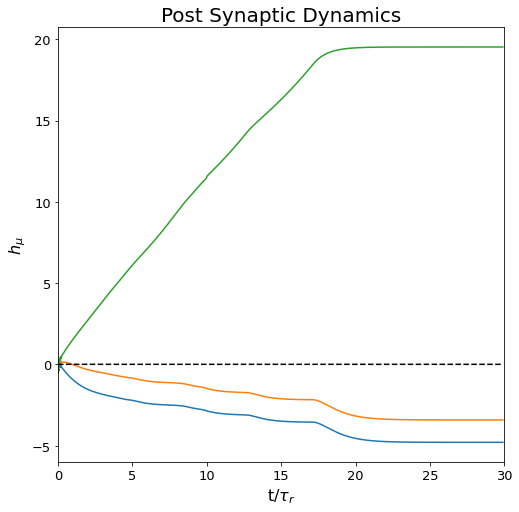

In [11]:
#---Plot some post-synaptic activations ---
fig = plt.figure(figsize=(8,8))
plt.plot(tt,h[120,:], tt,h[6,:], tt,h[199,:])
plt.plot(tt,np.zeros(lt1+lt2),'k--')
plt.xlim((0,tmax2/tau_r))
plt.title('Post Synaptic Dynamics',fontsize=20)
plt.xlabel('t/$\\tau_{r}$',fontsize=16)
plt.ylabel('$h_\mu$',fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### 2° Step: $W_{\mu,i}$ - ODE

In [12]:
#---Activation Function
def g(h_steady, h_star, delta):
  gh = np.ones((len(h_steady),1))*delta
  gh[h_steady >= h_star] = 1
  gh[h_steady < 0] = 0
  return gh

In [13]:
#functions weights update
def W_update(ghp,vp,Wp):
  Wnew = np.zeros((neurons_hidden,neurons_input))

  conv = np.zeros((neurons_hidden,lt3))
  conv[:,0]=np.sum(W**2,axis=1)

  dt3_tau = dt3/tau_w
  ghv  = (ghp*vp.T)*dt3_tau

  for j in range(1,lt3):
    I_w = np.matmul(Wp,vp)
    T = np.matmul(ghp*I_w,np.ones((1,neurons_input)))  
    Wp = Wp + ghv - T*Wp*dt3_tau   

    conv[:,j] = np.sum(Wp**2,axis=1) #comment this line to speed up training loop
 
  return Wp, conv

def W_update_quick(ghp,vp,Wp):
  Wnew = np.zeros((neurons_hidden,neurons_input))
  dt3_tau = dt3/tau_w
  ghv  = (ghp*vp.T)*dt3_tau

  for j in range(1,lt3):
    I_w = np.matmul(Wp,vp)
    T = np.matmul(ghp*I_w,np.ones((1,neurons_input))) 
    Wp = Wp + ghv - T*Wp*dt3_tau      

  return Wp

In [14]:
#---Parameters 2° ODE---
delta  = -0.01
t = time.time()
gh = g(h_steady, h_star, delta)
print('Activation applied in: ',np.round(time.time() - t,3),'s')

tau_w = 5
tmax3 = 2.5
dt3 = 0.02
t3 = np.arange(0,tmax3,dt3)/tau_w
lt3 = len(t3)

t = time.time()
W_new, conv = W_update(gh, v, W)
print('2° ODE solved in: ',np.round(time.time() - t,3),'s')

Activation applied in:  0.003 s
2° ODE solved in:  1.002 s


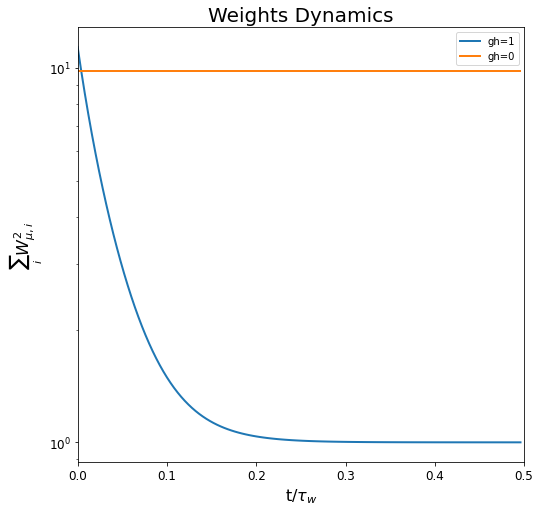

In [15]:
#--- Sample some weight dynamics
w1 = np.random.choice(np.argwhere(gh==1)[:,0])

w0 = np.random.choice(np.argwhere(gh==0)[:,0])

#---Plot some weights dyanmics ---
fig = plt.figure(figsize=(8,8))
plt.plot(t3,conv[w1],label='gh=1', linewidth=2)

if np.sum(gh==delta)!=0:
  wd = np.random.choice(np.argwhere(gh==delta)[:,0])
  plt.plot(t3,conv[wd],label='gh=$\Delta$', linewidth=2)
  
plt.plot(t3,conv[w0],label='gh=0', linewidth=2)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim((0,tmax3/tau_w))
plt.xlabel('t/$\\tau_w$',fontsize=16)
plt.ylabel('$\sum_{i} W_{\mu,i}^2$',fontsize=16)
plt.title('Weights Dynamics',fontsize=20)
plt.legend()
plt.show()

### Full Training

In [17]:
#---Initialization
neurons_hidden = 484
h_steady = np.zeros(neurons_hidden)
np.random.seed(2347)
sigma = 0.2
W_first = sigma*np.random.rand( neurons_hidden, neurons_input) 
W = W_first

winh   =  1.3
delta  = -0.05
h_star = 7
tau_r  = 0.01
tau_w  = 5
#---Training
max_samples = 800  #1.34% of the dataset
np.random.seed(43782)
sample_indexs = np.random.randint(0, dataset_size-1, max_samples)

In [18]:
#Custom number of Samples

def random_sample_index ( max_samples, mode = "uniform"):
  if mode == "uniform":
    max_samples_class = max_samples/num_classes

  elif mode == "custom":
    max_samples_class = max_samples*np.array([0.05, 0.05, 0.075, 0.15, 0.15, 0.15, 0.05, 0.05, 0.125, 0.15 ])
  else:
    print("Not found modality")
  s0=np.random.choice(np.argwhere(train_dataset.targets==0)[0], int(max_samples_class[0]))
  s1=np.random.choice(np.argwhere(train_dataset.targets==1)[0], int(max_samples_class[1]))
  s2=np.random.choice(np.argwhere(train_dataset.targets==2)[0], int(max_samples_class[2]))
  s3=np.random.choice(np.argwhere(train_dataset.targets==3)[0], int(max_samples_class[3]))
  s4=np.random.choice(np.argwhere(train_dataset.targets==4)[0], int(max_samples_class[4]))
  s5=np.random.choice(np.argwhere(train_dataset.targets==5)[0], int(max_samples_class[5]))
  s6=np.random.choice(np.argwhere(train_dataset.targets==6)[0], int(max_samples_class[6]))
  s7=np.random.choice(np.argwhere(train_dataset.targets==7)[0], int(max_samples_class[7]))
  s8=np.random.choice(np.argwhere(train_dataset.targets==8)[0], int(max_samples_class[8]))
  s9=np.random.choice(np.argwhere(train_dataset.targets==9)[0], int(max_samples_class[9]))
  sample_indexs = np.concatenate([s0, s1, s2, s3, s4, s5, s6, s7, s8, s9])
  sample_indexs = np.random.permutation(sample_indexs)
  return sample_indexs

sample_indexs = random_sample_index(max_samples=max_samples, mode="custom" )


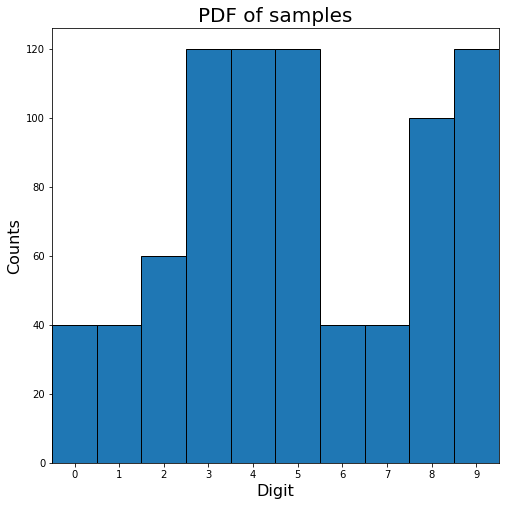

In [19]:
fig = plt.figure(figsize=(8,8))
plt.hist(train_dataset.targets[sample_indexs], bins=np.arange(-0.5,10.5,1), edgecolor="k")
plt.xlim((-0.5,9.5))
plt.xticks(np.arange(0,10,1))
plt.title('PDF of samples',fontsize=20)
plt.xlabel('Digit',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.show()

In [20]:
t = time.time()
for sample_index in tqdm(sample_indexs):

  #extract sample from the dataset
  image = train_dataset[sample_index][0]

  #wait until steady state activation
  v = torch.flatten(image).unsqueeze(dim=1).numpy()
  I = np.matmul(W,v).squeeze()
  h_steady = hsteady_quick(h_steady,I)

  #apply non linear learning activation g
  gh = g(h_steady, h_star, delta)

  #update weights W
  W = W_update_quick(gh, v, W)


weight_divergence = np.sum(np.abs(W_first-W))/n_synapsis  

print('\n',max_samples, ' images processed in: ',np.around(time.time() - t,3),'s')
print('\n','weight divergence: ', weight_divergence)

100%|██████████| 800/800 [10:17<00:00,  1.30it/s]


 800  images processed in:  617.384 s

 weight divergence:  0.09051426919108946


In [21]:
#code taken from https://github.com/DimaKrotov/Biological_Learning

def draw_weights(synapses, Kx, Ky, img_shape):
    yy=0
    HM=np.zeros((img_shape*Ky,img_shape*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*img_shape:(y+1)*img_shape,x*img_shape:(x+1)*img_shape]=synapses[yy,:].reshape(img_shape,img_shape)
            yy += 1

    fig = plt.figure(figsize=(15,15))
    plt.clf()

    nc = np.amax(np.absolute(HM))

    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)

    fig.colorbar(im,ticks=np.linspace(-nc,nc,7),fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.show()

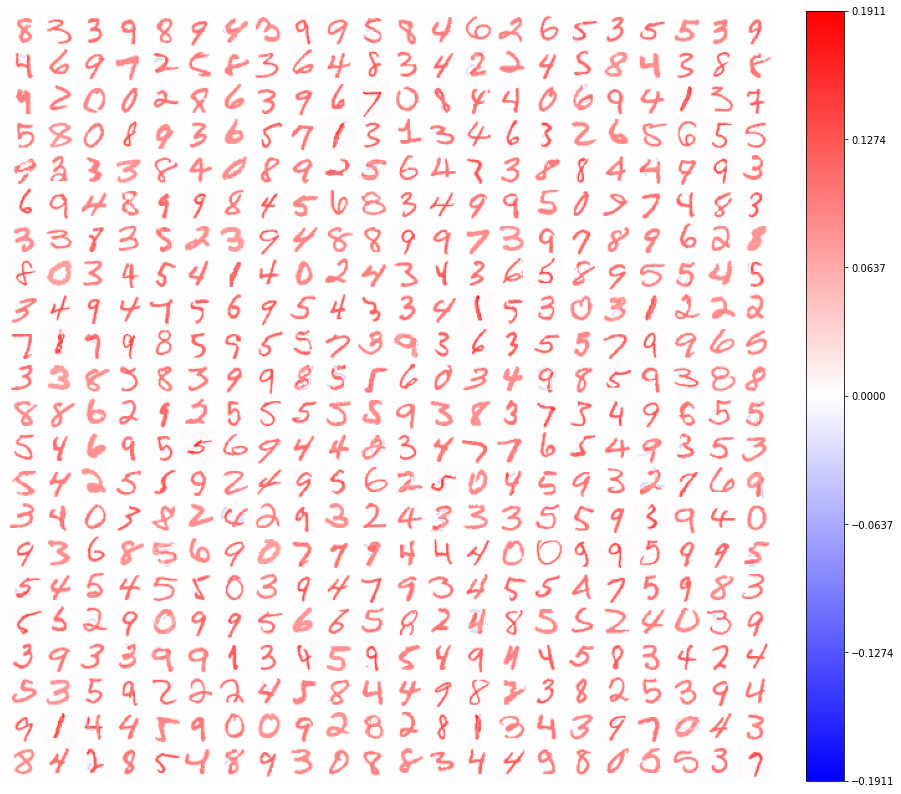

In [22]:
torch.save(W, 'BIO_TRAIN_layer1.pth')
W = torch.load('BIO_TRAIN_layer1.pth')

K = int(np.sqrt(neurons_hidden))
draw_weights(W, K, K, 28) 

# Super-Active Neurons

SAMPLE AT INDEX 7052
LABEL: 0


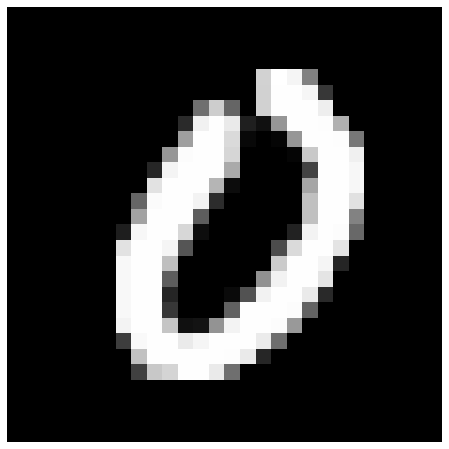

In [23]:
np.random.seed(2347)
digit = 0
s0=np.random.choice(np.argwhere(test_dataset.targets==digit)[0])
image=test_dataset[s0][0]
plot_sample(s0,0)

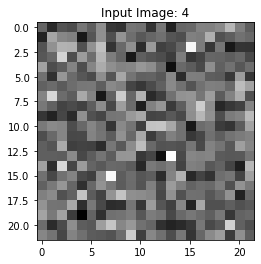

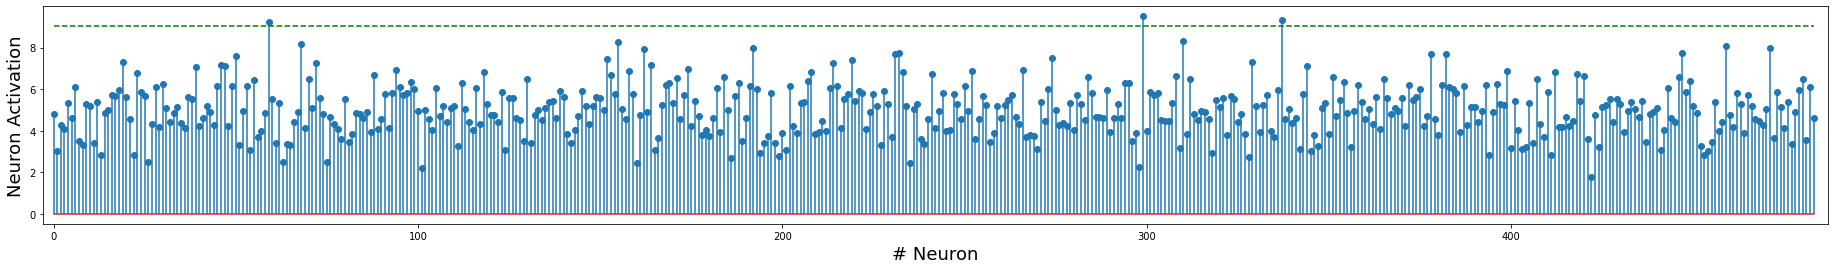

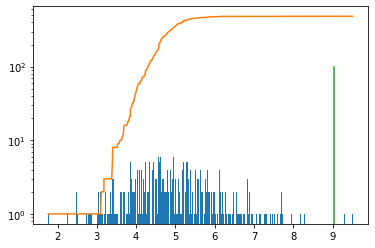

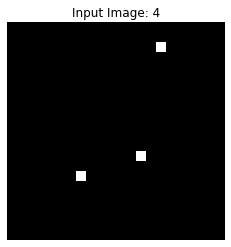

In [24]:
v = torch.flatten(image).unsqueeze(dim=1).numpy()
v1_flat = np.matmul(W,v)
X = np.matmul(W,v)
th = 0.95*np.max(v1_flat)
v1 = np.reshape(v1_flat,(K,K))
plt.imshow(v1,cmap="gray")
plt.title("Input Image: "+str(train_dataset[sample_index][1]))
plt.show()

plt.figure(figsize=(32,4))
plt.stem(np.arange(neurons_hidden), v1_flat, use_line_collection = True)
plt.plot(np.arange(neurons_hidden), th*np.ones(neurons_hidden),'g--')
plt.xlim((-3,neurons_hidden+3))
plt.xlabel('# Neuron',fontsize=18)
plt.ylabel('Neuron Activation',fontsize=18)
plt.show()

count, _ ,_ = plt.hist(v1_flat, bins=neurons_hidden)
plt.plot(np.sort(np.reshape(v1_flat,(neurons_hidden,))) , np.cumsum(count))
plt.yscale('log')
plt.plot(th*np.ones(100),np.arange(0,100,1))
plt.show()

v1_digit0 = v1

v1_digit0[v1_digit0<=th]=0
v1_digit0[v1_digit0>th]=1

plt.imshow(v1_digit0,cmap="gray")
plt.title("Input Image: "+str(train_dataset[sample_index][1]))
plt.axis('off')
plt.show()

In [25]:
ar_fm = len(np.where(X>th)[0])
index_neuron = np.where(X>th)[0]
print('Super Active Neuron n°:',index_neuron)

Super Active Neuron n°: [ 59 299 337]


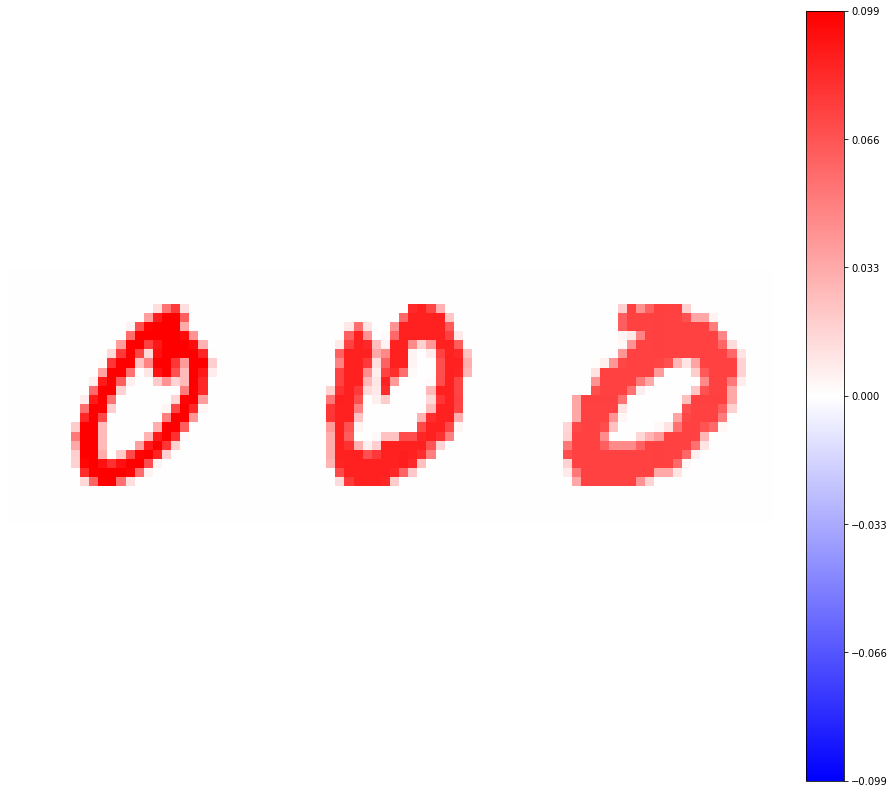

In [26]:
draw_weights(W[np.where(X>th)[0],:], ar_fm, 1, 28) 

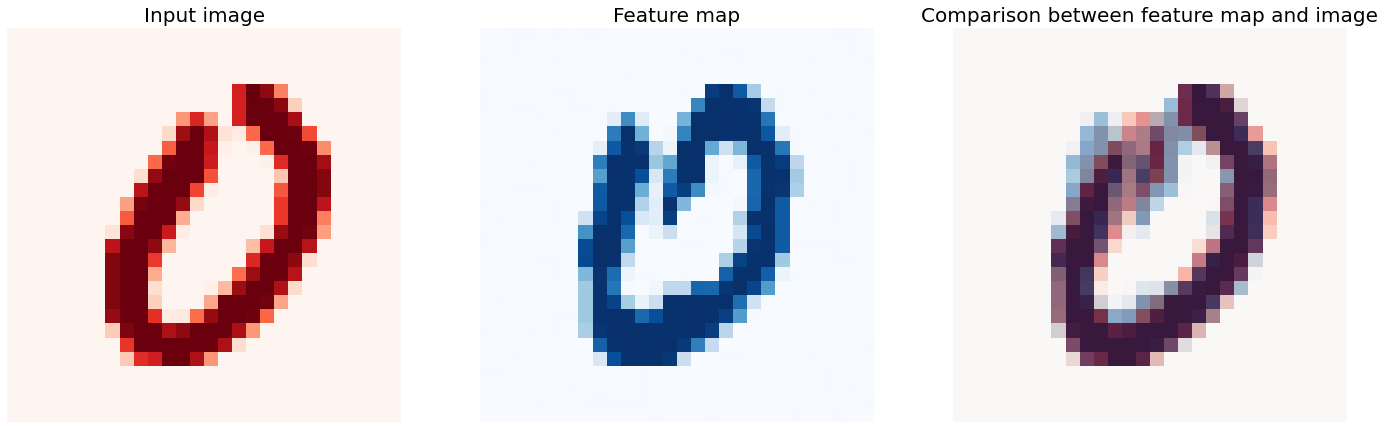

In [27]:
fig, axs = plt.subplots(1,3,figsize=(24,8))
I = np.random.choice(index_neuron)
axs[2].set_title('Comparison between feature map and image',fontsize=20)
axs[2].imshow(np.reshape(W[I,:],(28,28)),cmap="Blues",alpha=1)
axs[2].imshow(image.squeeze().numpy(),cmap="Reds",alpha=0.5)
axs[2].axis('off')
axs[1].set_title('Feature map',fontsize=20)
axs[1].imshow(np.reshape(W[I,:],(28,28)),cmap="Blues",alpha=1)
axs[1].axis('off')
axs[0].set_title('Input image',fontsize=20)
axs[0].imshow(image.squeeze().numpy(),cmap="Reds",alpha=1)
axs[0].axis('off')
plt.show()

# Supervised Phase

##Training half BIO - half BP

In [28]:
class Net2(nn.Module):
    
  def __init__(self, Nh1, Nh2, Nh3):
        """
        Nh1 - Neurons in the input  layer
        Nh2 - Neurons in the hidden layer
        Nh3 - Neurons in the output layer
        """
        super().__init__()
        
        print('Network initialized')
        self.f0 = nn.Flatten()
        with torch.no_grad():
          self.f1 = nn.Linear(in_features=Nh1,  out_features=Nh2, bias=False)
        self.f2 = nn.Linear(in_features=Nh2,  out_features=Nh3, bias=False)
        self.act = nn.ReLU()

  def forward(self, x, additional_out=False):
        x = self.f0(x)
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        return x

In [29]:
#---Initialize the network
torch.manual_seed(0)
Nh1 = neurons_input
Nh2 = neurons_hidden
Nh3 = num_classes
net3 = Net2(Nh1, Nh2, Nh3)

#---Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net3.to(device) 

Network initialized
Training device: cpu


Net2(
  (f0): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=784, out_features=484, bias=False)
  (f2): Linear(in_features=484, out_features=10, bias=False)
  (act): ReLU()
)

In [30]:
#FOR TRAINING
#---Freeze the first layer 
with torch.no_grad():
    net3.f1.weight.copy_(torch.tensor(W))
net3.f1.weight.requires_grad = False

In [31]:
K_fold = 5
max_epochs = 11
nn_final = NeuralNetClassifier(module=net3, max_epochs=max_epochs, lr=0.005,
                               train_split=ValidSplit(K_fold), optimizer=optim.Adam, criterion=torch.nn.CrossEntropyLoss,
                               iterator_train__shuffle=True)

c = nn_final.get_iterator(train_dataloader.dataset)
nn_final.fit(c.dataset,y=None)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0881       0.8445        0.5226  7.1976
      2        0.5358       0.8512        0.4863  7.0028
      3        0.5269       0.8878        0.3888  6.9145
      4        0.5445       0.8649        0.4720  6.9486
      5        0.5102       0.8782        0.4360  6.8744
      6        0.5265       0.8542        0.5214  6.8887
      7        0.4982       0.8175        0.6612  6.9366
      8        0.5104       0.8621        0.4853  7.4633
      9        0.4899       0.8566        0.5017  6.9463
     10        0.5274       0.8756        0.4680  7.0259
     11        0.5350       0.8692        0.4990  7.8864


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net2(
    (f0): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=784, out_features=484, bias=False)
    (f2): Linear(in_features=484, out_features=10, bias=False)
    (act): ReLU()
  ),
)

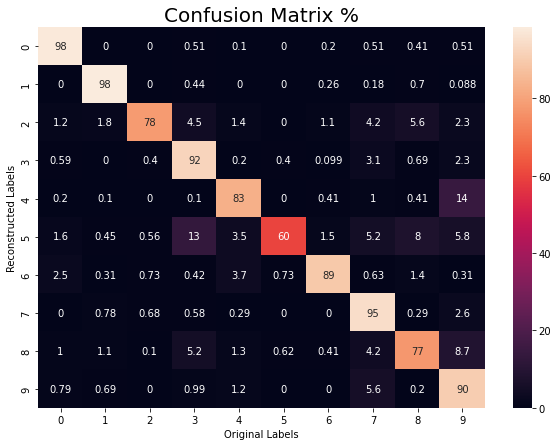

Final Test Accuray:  86.61 %


In [32]:
d = nn_final.get_iterator(test_dataloader.dataset)
y_pred = nn_final.predict(d.dataset)
CM= confusion_matrix(d.dataset.targets.cpu().numpy(), y_pred, labels=np.arange(10))

plt.figure(figsize = (10,7))
cm = CM
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmn, annot=True, xticklabels=np.arange(0,num_classes), yticklabels=np.arange(0,num_classes))
plt.title('Confusion Matrix %',fontsize=20)
plt.xlabel('Original Labels')
plt.ylabel('Reconstructed Labels')
plt.show()

print('Final Test Accuray: ',np.round(100*cm.diagonal().sum()/cm.sum(),2),'%')

## Training only with BP

In [33]:
#---Initialize the network
torch.manual_seed(0)
Nh1 = neurons_input
Nh2 = neurons_hidden
Nh3 = num_classes
net4 = Net2(Nh1, Nh2, Nh3)

#---Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net4.to(device) 

Network initialized
Training device: cpu


Net2(
  (f0): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=784, out_features=484, bias=False)
  (f2): Linear(in_features=484, out_features=10, bias=False)
  (act): ReLU()
)

In [34]:
K_fold = 5
max_epochs = 11
nn_final1 = NeuralNetClassifier(module=net4, max_epochs=max_epochs, lr=0.005,
                               train_split=ValidSplit(K_fold), optimizer=optim.Adam, criterion=torch.nn.CrossEntropyLoss,
                               iterator_train__shuffle=True)

c = nn_final1.get_iterator(train_dataloader.dataset)
nn_final1.fit(c.dataset,y=None)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2268       0.9607        0.1275  9.0839
      2        0.0916       0.9622        0.1275  9.0716
      3        0.0617       0.9695        0.1070  13.3878
      4        0.0486       0.9692        0.1126  9.4514
      5        0.0378       0.9752        0.1004  9.5374
      6        0.0326       0.9755        0.0995  9.5556
      7        0.0282       0.9763        0.1060  9.6723
      8        0.0275       0.9765        0.1056  9.7419
      9        0.0213       0.9738        0.1364  9.7107
     10        0.0297       0.9751        0.1343  9.7512
     11        0.0251       0.9687        0.1864  9.8256


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net2(
    (f0): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=784, out_features=484, bias=False)
    (f2): Linear(in_features=484, out_features=10, bias=False)
    (act): ReLU()
  ),
)

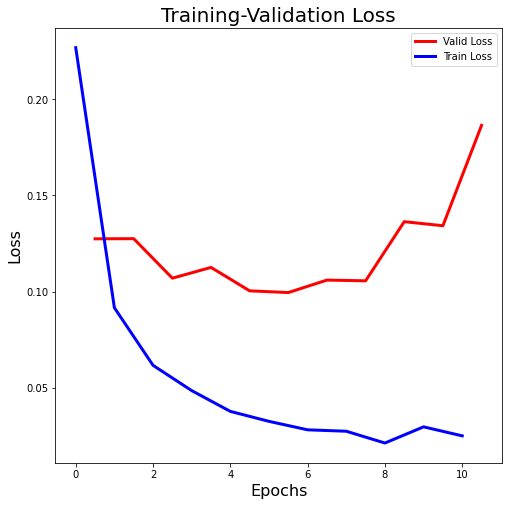

In [35]:
history = nn_final1.history

plt.figure(figsize = (8,8))
plt.plot(np.arange(0.5,max_epochs+0.5,1),history[:, 'valid_loss'], 'r',linewidth=3, label='Valid Loss')
plt.plot(np.arange(0,max_epochs),history[:, 'train_loss'], 'b',linewidth=3, label='Train Loss')
plt.title('Training-Validation Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(np.arange(0,max_epochs,2))
plt.legend()
plt.show()

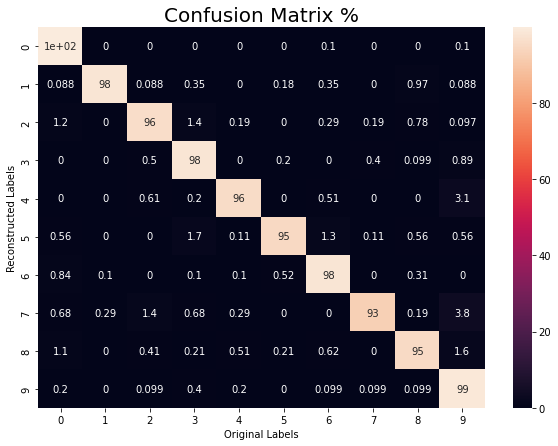

Final Test Accuray:  96.72 %


In [36]:
d = nn_final1.get_iterator(test_dataloader.dataset)
y_pred = nn_final1.predict(d.dataset)
CM= confusion_matrix(d.dataset.targets.cpu().numpy(), y_pred, labels=np.arange(10))

plt.figure(figsize = (10,7))
cm = CM
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmn, annot=True, xticklabels=np.arange(0,num_classes), yticklabels=np.arange(0,num_classes))
plt.title('Confusion Matrix %',fontsize=20)
plt.xlabel('Original Labels')
plt.ylabel('Reconstructed Labels')
plt.show()

print('Final Test Accuray: ',np.round(100*cm.diagonal().sum()/cm.sum(),2),'%')

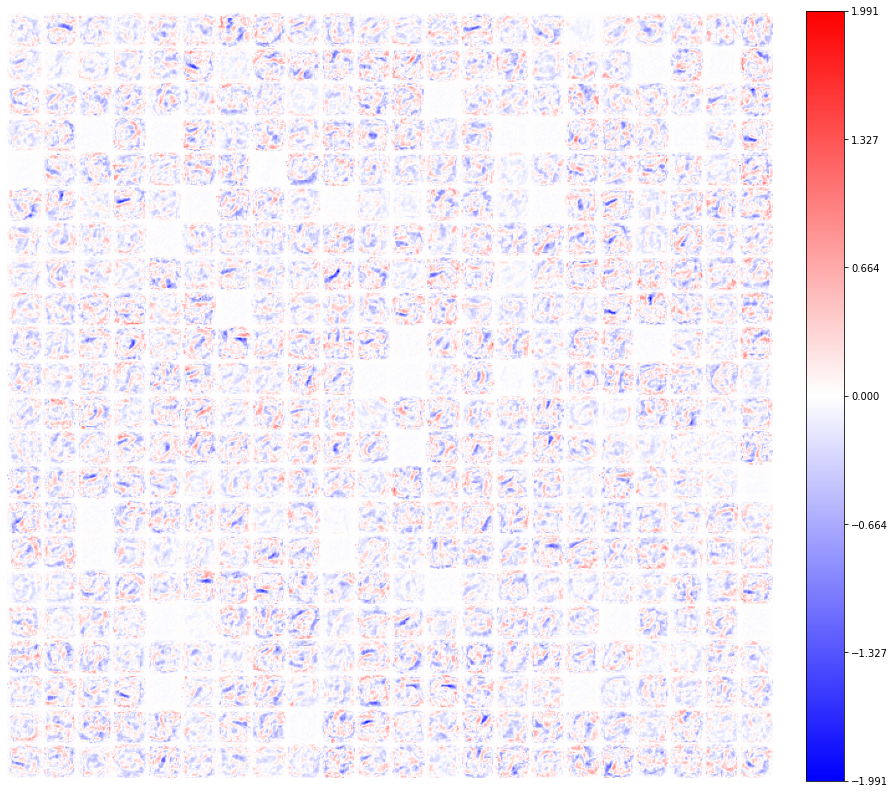

In [37]:
#feature maps 1
W1_BP = net4.f1.weight.detach().cpu().numpy()
draw_weights(W1_BP, K, K, 28)  

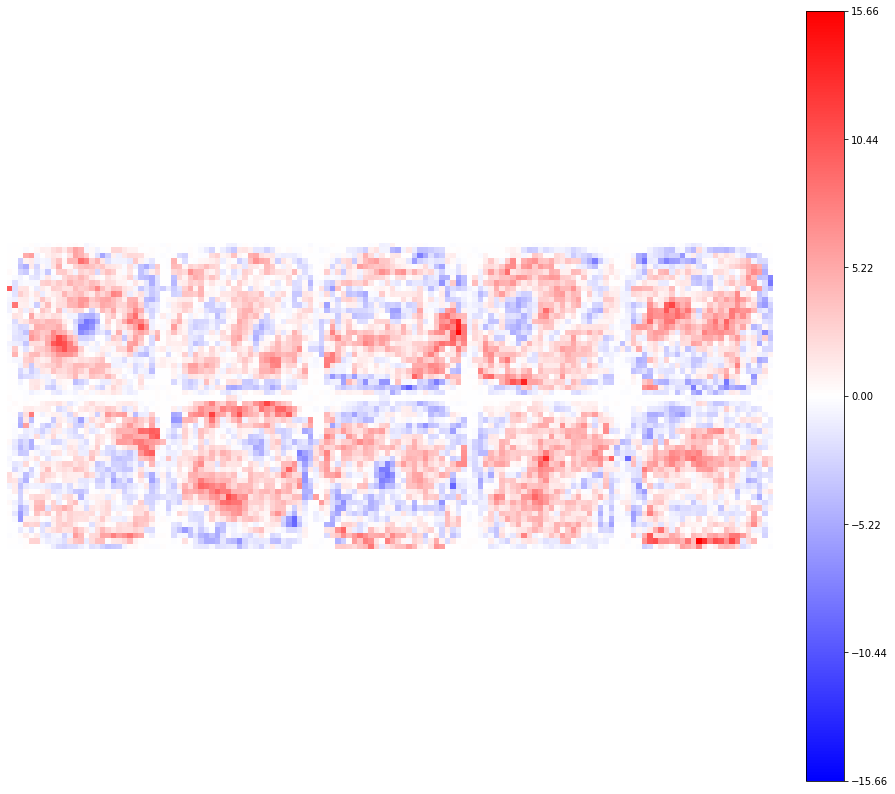

In [38]:
#print feature maps seen from the output neuron
W2_BP = net4.f2.weight.detach().cpu().numpy()
C_BP = np.zeros((num_classes,neurons_input))
for j in range(num_classes):
  for i in range(neurons_hidden):
    C_BP[j] +=  W1_BP[i]*W2_BP[j,i]
K1 = 5
K2 = 2
draw_weights(C_BP, K1, K2, 28) 

## Training with Proposed Algorithm

In [39]:
class Net(nn.Module):
    
    def __init__(self, Nh1, Nh2, Nh3):
        """
        Nh1 - Neurons in the input  layer
        Nh2 - Neurons in the hidden layer
        Nh3 - Neurons in the output layer
        """
        super().__init__()
        
        print('Network initialized')
        self.f0 = nn.Flatten()
        with torch.no_grad():
          self.f1 = nn.Linear(in_features=Nh1,  out_features=Nh2, bias=False)
        self.f2 = nn.Linear(in_features=Nh2,  out_features=Nh3, bias=False)
    

    def forward(self, x, additional_out=False):
        x = self.f0(x)
        x = self.f1(x)
        x = x-th*torch.max(x)
        x = torch.sigmoid(x*15)
        x = self.f2(x)
        return x

In [40]:
#---Initialize the network
torch.manual_seed(0)
Nh1 = neurons_input
Nh2 = neurons_hidden
Nh3 = num_classes
net1 = Net(Nh1, Nh2, Nh3)
th=0.95

#---Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net1.to(device) 

Network initialized
Training device: cpu


Net(
  (f0): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=784, out_features=484, bias=False)
  (f2): Linear(in_features=484, out_features=10, bias=False)
)

In [41]:
#FOR TRAINING
#---Freeze the first layer 
with torch.no_grad():
    net1.f1.weight.copy_(torch.tensor(W))
net1.f1.weight.requires_grad = False

### Probabilistic Heuristic

In [42]:
W = torch.load('BIO_TRAIN_layer1.pth')

In [44]:
#learn the matrix of weights W2
th=0.95
count_connections = np.zeros((num_classes,neurons_hidden))
W2_prob = np.zeros((num_classes,neurons_hidden))
c=0
for example in train_dataloader: #50000 images
    data, label = example
    v = torch.flatten(data).unsqueeze(dim=1).numpy()
    I = np.matmul(W,v).squeeze()
    I = np.heaviside(I-th*np.max(I),1)
    I = I.astype(int)
    ind = np.where(I==1)
    count_connections[label,ind] += 1
    c+=1
count_per_neuron = np.sum(count_connections,axis=0)
W2_prob = count_connections/(count_per_neuron+np.finfo(float).eps)

torch.save(W2_prob, 'BIO_TRAIN_layer2.pth')

In [45]:
#evaluate test accuracy 
labels_o = []
labels_n = []

P_D = W2_prob*(count_per_neuron)/c
d=0
softmax = "yes"
for example in test_dataloader:
    d+=1
    data, label_o = example
    labels_o.append(label_o.numpy()[0])
    v = torch.flatten(data).unsqueeze(dim=1).numpy()
    I = np.matmul(W,v).squeeze()
    I = np.heaviside(I-th*np.max(I),1)

    if softmax == "yes":
      I2 = np.matmul(W2_prob,I)
      prob = scipy.special.softmax(I2, axis=None)
      label_n = np.where(prob==np.max(prob))
    elif softmax=="no":
      I2 = np.matmul(P_D,I)
      label_n = np.where(I2==np.max(I2))

    labels_n.append(label_n[0][0])

10000


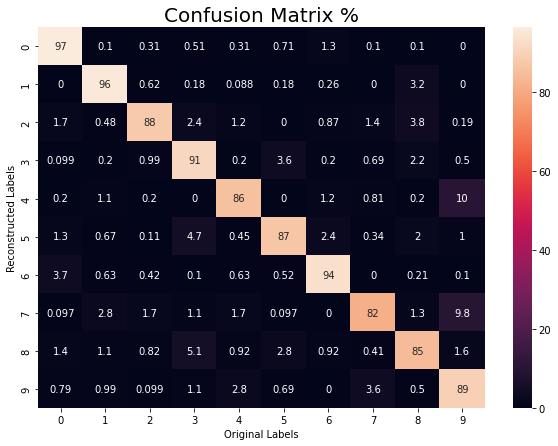

Final Test Accuray:  89.45 %


In [46]:
CM= confusion_matrix(labels_o, labels_n, labels=np.arange(10))

plt.figure(figsize = (10,7))
cm = CM
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmn, annot=True, xticklabels=np.arange(0,num_classes), yticklabels=np.arange(0,num_classes))
plt.title('Confusion Matrix %',fontsize=20)
plt.xlabel('Original Labels')
plt.ylabel('Reconstructed Labels')
plt.show()

print('Final Test Accuray: ',np.round(100*cm.diagonal().sum()/cm.sum(),2),'%')

### Check Feature Map

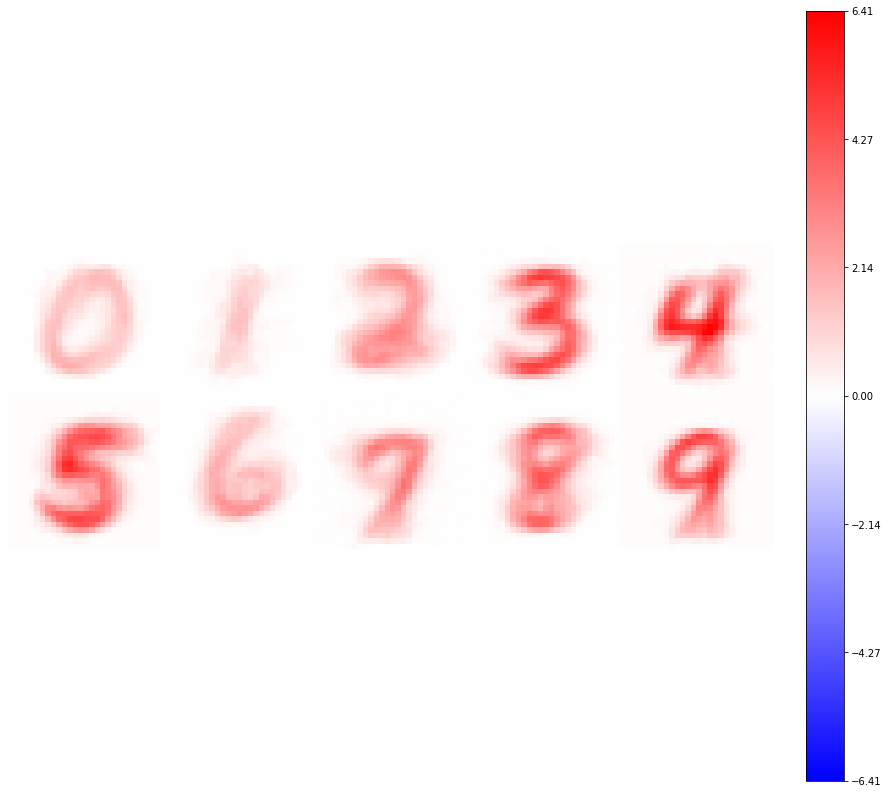

In [47]:
#print feature maps seen from the output neuron
C = np.zeros((num_classes,neurons_input))
for j in range(num_classes):
  for i in range(neurons_hidden):
    C[j] +=  W[i]*W2_prob[j,i]
K1 = 5
K2 = 2
draw_weights(C, K1, K2, 28) 

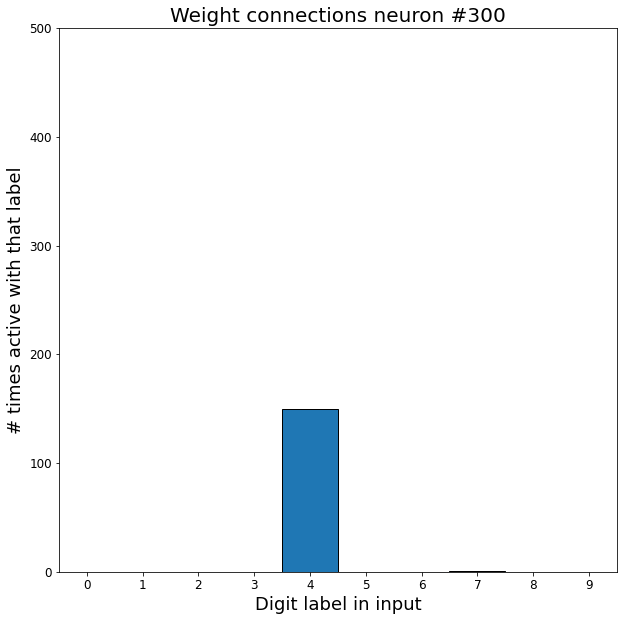

In [48]:
#visualization of the vector of counts for a random neuron
fig = plt.subplots(1,1,figsize=(10,10))
plt.bar(np.arange(0,10),count_connections.T[300,:], width=1, bottom=0,edgecolor="black")
plt.axis([-0.5,9.5,0,500])
plt.xticks(np.arange(0,10),fontsize=12)
plt.yticks(fontsize=12)
plt.title('Weight connections neuron #300', fontsize=20)
plt.xlabel("Digit label in input", fontsize=18)
plt.ylabel("# times active with that label", fontsize=18)
plt.show()

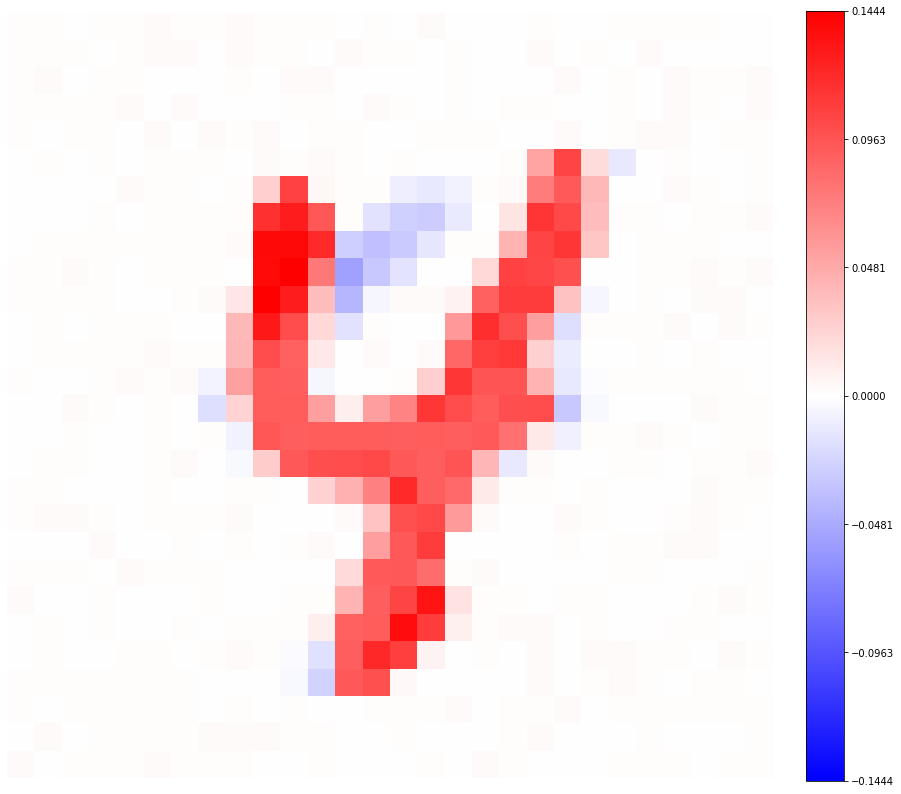

In [49]:
#feature map embedded in the random neuron
draw_weights(W[[300],:], 1, 1, 28) 

# FGSM Adversarial Attack


In [50]:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [51]:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    orig_examples = []
    

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
       
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = FF.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                orig_examples.append(data.squeeze().detach().cpu().numpy())
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                orig_examples.append(data.squeeze().detach().cpu().numpy())

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, orig_examples

## Attack on BNN, with full BP

In [52]:
#evaluate test accuracy under attack
torch.manual_seed(3555435)
accuraciesONN = []
examples = []
orig = []
net4.eval()
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex, org = test(net4, device, test_dataloader, eps)
    accuraciesONN.append(acc)
    examples.append(ex)
    orig.append(org)

Epsilon: 0	Test Accuracy = 9672 / 10000 = 0.9672
Epsilon: 0.05	Test Accuracy = 7200 / 10000 = 0.72
Epsilon: 0.1	Test Accuracy = 2913 / 10000 = 0.2913
Epsilon: 0.15	Test Accuracy = 844 / 10000 = 0.0844
Epsilon: 0.2	Test Accuracy = 286 / 10000 = 0.0286
Epsilon: 0.25	Test Accuracy = 94 / 10000 = 0.0094
Epsilon: 0.3	Test Accuracy = 48 / 10000 = 0.0048


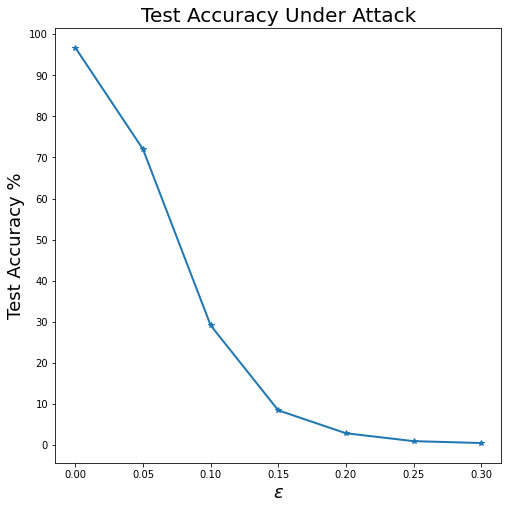

In [53]:
#visualize test accuracy under attack profile
plt.figure(figsize=(8,8))
plt.plot(epsilons, np.array(accuraciesONN)*100, "*-", linewidth=2)
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(epsilons)
plt.title("Test Accuracy Under Attack",fontsize=20)
plt.xlabel("$\epsilon$",fontsize=18)
plt.ylabel("Test Accuracy %", fontsize=18)
#plt.yscale('log')
plt.show()

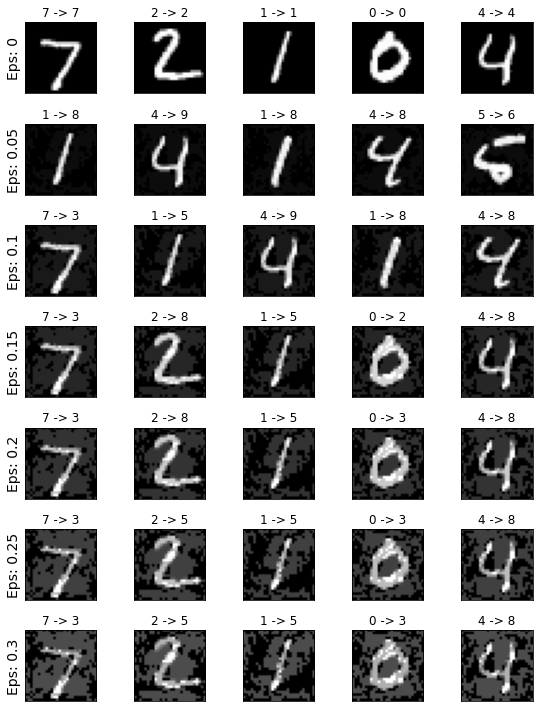

In [54]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        original,adv,ex = examples[i][j]
        orig_img = orig[i][j]
        plt.title("{} -> {}".format(original, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Attack on half BIO - half BP

In [55]:
#evaluate test accuracy under attack
torch.manual_seed(3555435)
accuraciesANN = []
examples = []
orig = []
net3.eval()
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex, org = test(net3, device, test_dataloader, eps)
    accuraciesANN.append(acc)
    examples.append(ex)
    orig.append(org)

Epsilon: 0	Test Accuracy = 8661 / 10000 = 0.8661
Epsilon: 0.05	Test Accuracy = 7664 / 10000 = 0.7664
Epsilon: 0.1	Test Accuracy = 5734 / 10000 = 0.5734
Epsilon: 0.15	Test Accuracy = 3515 / 10000 = 0.3515
Epsilon: 0.2	Test Accuracy = 1905 / 10000 = 0.1905
Epsilon: 0.25	Test Accuracy = 704 / 10000 = 0.0704
Epsilon: 0.3	Test Accuracy = 147 / 10000 = 0.0147


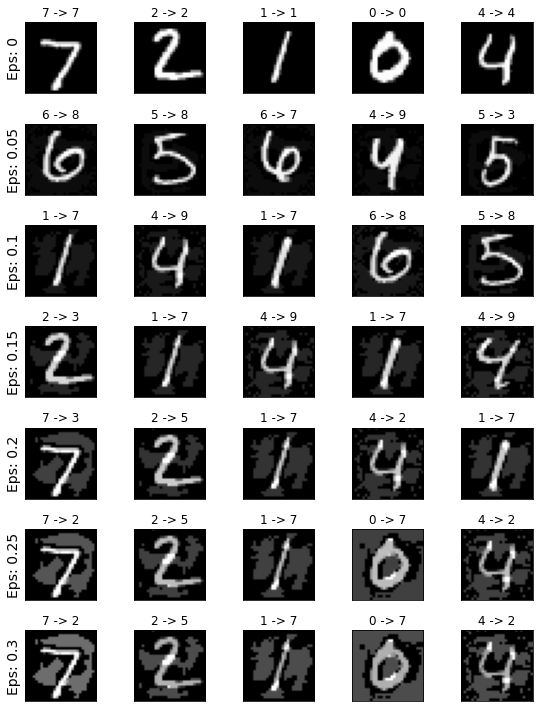

In [56]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        original,adv,ex = examples[i][j]
        orig_img = orig[i][j]
        plt.title("{} -> {}".format(original, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

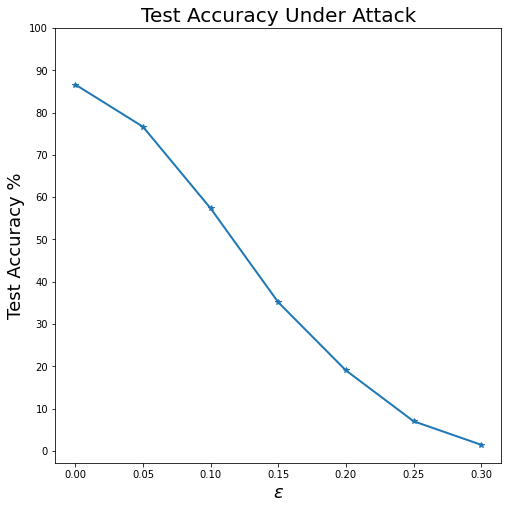

In [57]:
#visualize test accuracy under attack profile
plt.figure(figsize=(8,8))
plt.plot(epsilons, np.array(accuraciesANN)*100, "*-", linewidth=2)
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(epsilons)
plt.title("Test Accuracy Under Attack",fontsize=20)
plt.xlabel("$\epsilon$",fontsize=18)
plt.ylabel("Test Accuracy %", fontsize=18)
#plt.yscale('log')
plt.show()

## Attack on BNN, with proposed algorithm

In [62]:
with torch.no_grad():
    net1.f1.weight.copy_(torch.tensor(W))
    net1.f2.weight.copy_(torch.tensor(W2_prob))
net1.f1.weight.requires_grad = False

In [63]:
#evaluate test accuracy under attack
torch.manual_seed(3555435)
accuraciesBNN1 = []
examples = []
orig = []
net1.eval()
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex, org = test(net1, device, test_dataloader, eps)
    accuraciesBNN1.append(acc)
    examples.append(ex)
    orig.append(org)

Epsilon: 0	Test Accuracy = 9020 / 10000 = 0.902
Epsilon: 0.05	Test Accuracy = 8653 / 10000 = 0.8653
Epsilon: 0.1	Test Accuracy = 8531 / 10000 = 0.8531
Epsilon: 0.15	Test Accuracy = 8505 / 10000 = 0.8505
Epsilon: 0.2	Test Accuracy = 8505 / 10000 = 0.8505
Epsilon: 0.25	Test Accuracy = 8503 / 10000 = 0.8503
Epsilon: 0.3	Test Accuracy = 8498 / 10000 = 0.8498


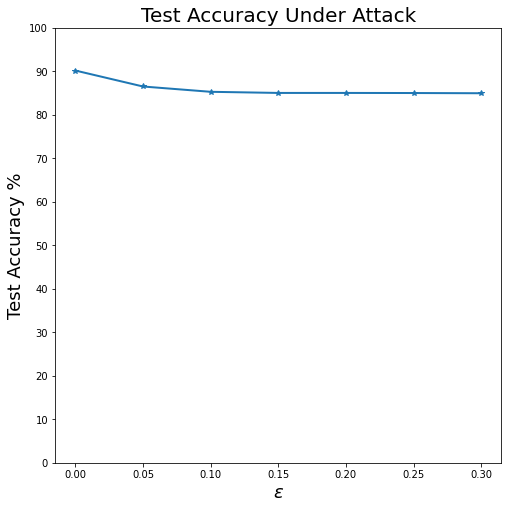

In [64]:
#visualize test accuracy under attack profile
plt.figure(figsize=(8,8))
plt.plot(epsilons, np.array(accuraciesBNN1)*100, "*-", linewidth=2)
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(epsilons)
plt.title("Test Accuracy Under Attack",fontsize=20)
plt.xlabel("$\epsilon$",fontsize=18)
plt.ylabel("Test Accuracy %", fontsize=18)
#plt.yscale('log')
plt.show()

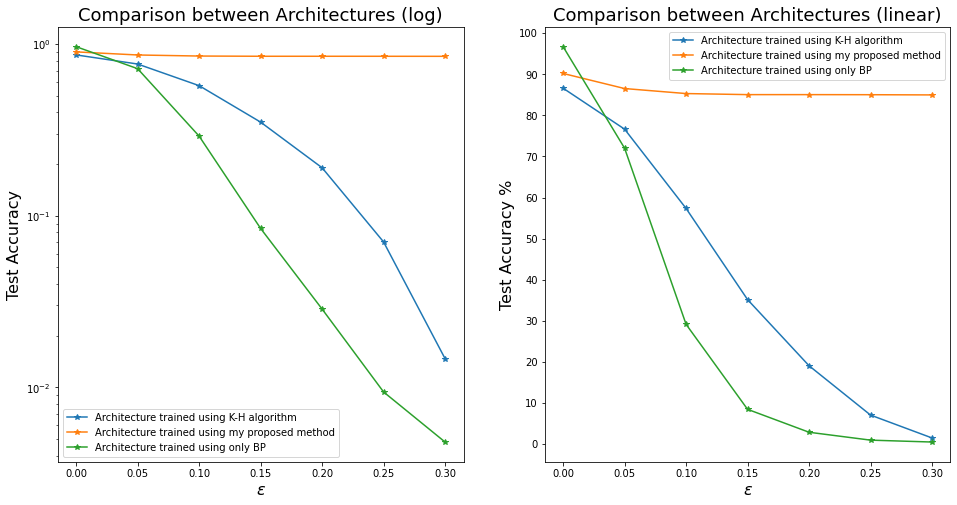

In [65]:
#visualize test accuracy under attack profile
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(epsilons, accuraciesANN, "*-", label = "Architecture trained using K-H algorithm")
axs[0].plot(epsilons, accuraciesBNN1, "*-", label = "Architecture trained using my proposed method")
axs[0].plot(epsilons, accuraciesONN, "*-", label = "Architecture trained using only BP")
axs[0].set_yticks(np.arange(0, 1.1, step=0.1))
axs[0].set_xticks(np.arange(0, .35, step=0.05))
axs[0].set_title("Comparison between Architectures (log)",fontsize=18)
axs[0].set_xlabel("$\epsilon$",fontsize=16)
axs[0].set_ylabel("Test Accuracy",fontsize=16)
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(epsilons, np.array(accuraciesANN)*100, "*-", label = "Architecture trained using K-H algorithm")
axs[1].plot(epsilons, np.array(accuraciesBNN1)*100, "*-", label = "Architecture trained using my proposed method")
axs[1].plot(epsilons, np.array(accuraciesONN)*100, "*-", label = "Architecture trained using only BP")
axs[1].set_yticks(np.arange(0, 110, step=10))
axs[1].set_xticks(np.arange(0, .35, step=0.05))
axs[1].set_title("Comparison between Architectures (linear)",fontsize=18)
axs[1].set_xlabel("$\epsilon$",fontsize=16)
axs[1].set_ylabel("Test Accuracy %",fontsize=16)
axs[1].legend()
plt.show()

In [66]:
# test accuracy under attack
torch.manual_seed(3555435)
accuraciesBNN = []
examples = []
orig = []
net1.eval()
epsilons = [0, .1, .2, .3, .4, .5, .7, .8, .9, 1, 1.3, 1.7]
# Run test for each epsilon
for eps in epsilons:
    acc, ex, org = test(net1, device, test_dataloader, eps)
    accuraciesBNN.append(acc)
    examples.append(ex)
    orig.append(org)

Epsilon: 0	Test Accuracy = 9020 / 10000 = 0.902
Epsilon: 0.1	Test Accuracy = 8531 / 10000 = 0.8531
Epsilon: 0.2	Test Accuracy = 8505 / 10000 = 0.8505
Epsilon: 0.3	Test Accuracy = 8498 / 10000 = 0.8498
Epsilon: 0.4	Test Accuracy = 8465 / 10000 = 0.8465
Epsilon: 0.5	Test Accuracy = 8360 / 10000 = 0.836
Epsilon: 0.7	Test Accuracy = 7638 / 10000 = 0.7638
Epsilon: 0.8	Test Accuracy = 7081 / 10000 = 0.7081
Epsilon: 0.9	Test Accuracy = 6473 / 10000 = 0.6473
Epsilon: 1	Test Accuracy = 5850 / 10000 = 0.585
Epsilon: 1.3	Test Accuracy = 5850 / 10000 = 0.585
Epsilon: 1.7	Test Accuracy = 5850 / 10000 = 0.585


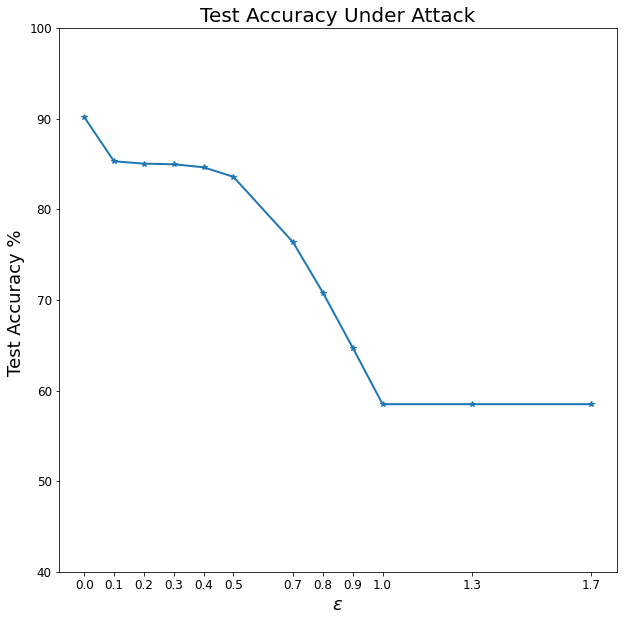

In [67]:
#visualize test accuracy under attack profile
plt.figure(figsize=(10,10))
plt.plot(epsilons, np.array(accuraciesBNN)*100, "*-", linewidth=2)
plt.yticks(np.arange(40, 110, step=10))
plt.xticks(epsilons, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Test Accuracy Under Attack",fontsize=20)
plt.xlabel("$\epsilon$",fontsize=18)
plt.ylabel("Test Accuracy % ", fontsize=18)
#plt.yscale('log')
plt.show()

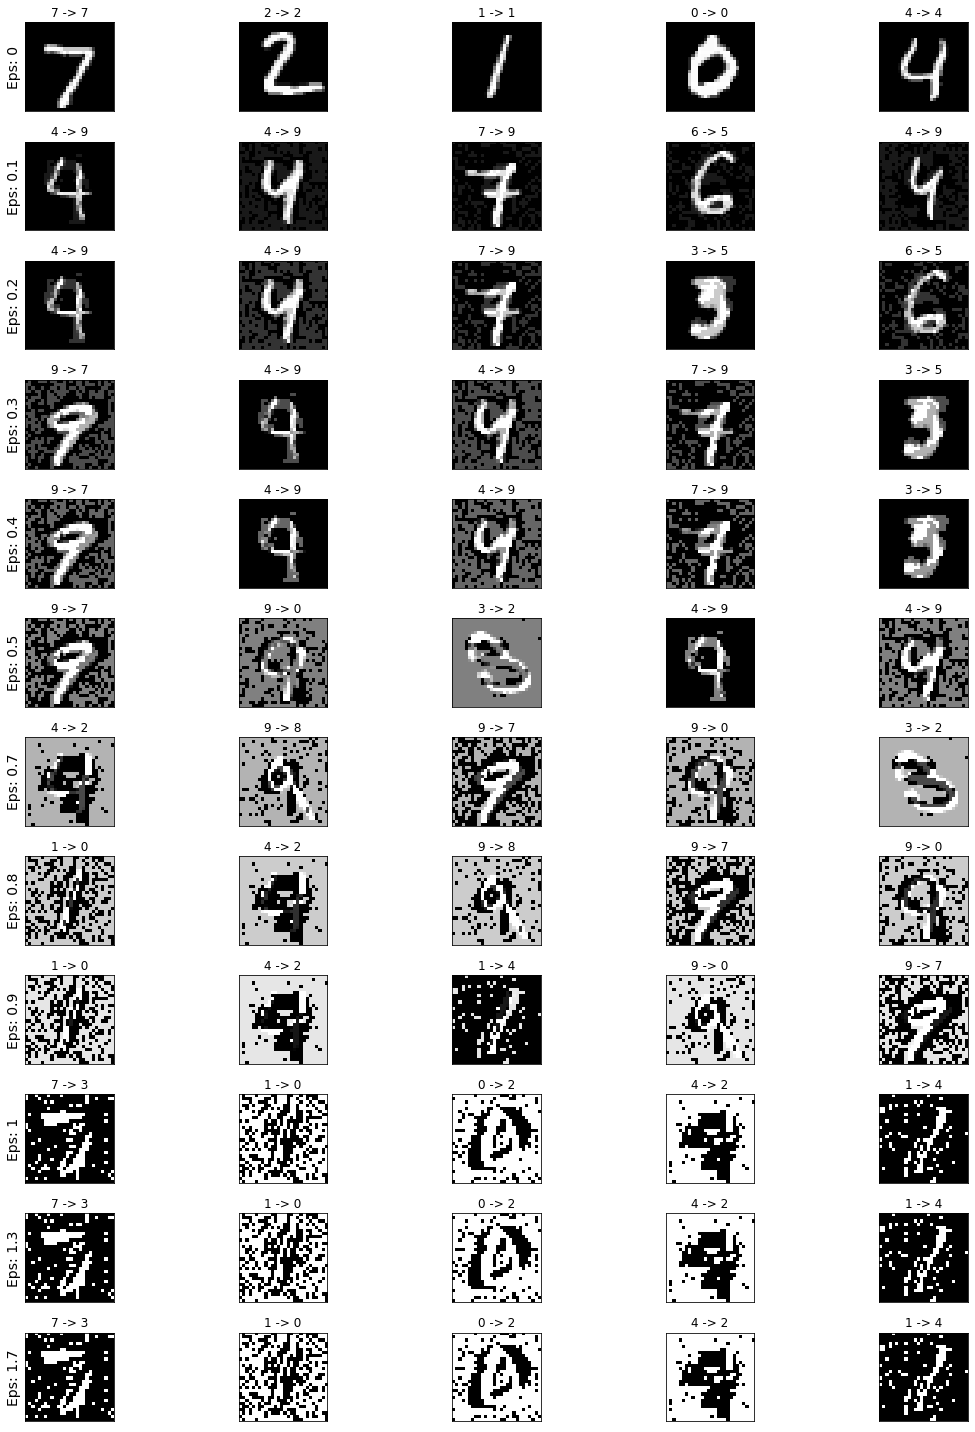

In [69]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(16,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        original,adv,ex = examples[i][j]
        orig_img = orig[i][j]
        plt.title("{} -> {}".format(original, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [70]:
ind = np.random.randint(5)
eps_ind = 3
ex = examples[eps_ind][ind][2]
orig_img = orig[eps_ind][ind]

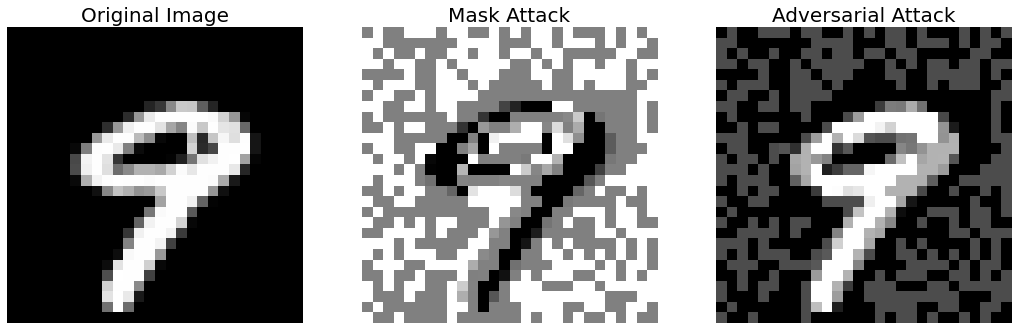

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
ax1.imshow(orig_img, cmap="gray")
ax1.set_title('Original Image',fontsize=20)
ax1.axis('off')
ax2.imshow(ex-orig_img, cmap="gray")
ax2.set_title('Mask Attack',fontsize=20)
ax2.axis('off')
ax3.imshow(ex, cmap="gray")
ax3.set_title('Adversarial Attack',fontsize=20)
ax3.axis('off')
plt.show()

# Benchmarking Adv. Attacks

In [72]:
atks = [
    FGSM(net1, eps=8/255),
    #BIM(net1, eps=8/255, alpha=2/255, steps=10),
    #RFGSM(net1, eps=8/255, alpha=2/255, steps=10),
    #CW(net1, c=0.0001, kappa=0, steps=1000, lr=0.01),
    #PGD(net1, eps=8/255, alpha=2/225, steps=10, random_start=True),
    #PGDL2(net1, eps=1, alpha=0.2, steps=40),
    #EOTPGD(net1, eps=8/255, alpha=2/255, steps=10, eot_iter=2),
    #FFGSM(net1, eps=8/255, alpha=10/255),
    #TPGD(net1, eps=8/255, alpha=2/255, steps=10),
    #MIFGSM(net1, eps=8/255, alpha=2/255, steps=10, decay=0.1),
    #VANILA(net1),
    #GN(net1, std=0.1),
    #APGD(net1, eps=8/255, steps=10, eot_iter=1, n_restarts=1, loss='ce'),
    #APGD(net1, eps=8/255, steps=10, eot_iter=1, n_restarts=1, loss='dlr'),
    #APGDT(net1, eps=8/255, steps=10, eot_iter=1, n_restarts=1),
    #FAB(net1, eps=8/255, steps=10, n_classes=10, n_restarts=1, targeted=False),
    #FAB(net1, eps=8/255, steps=10, n_classes=10, n_restarts=1, targeted=True),
    #Square(net1, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    #AutoAttack(net1, eps=8/255, n_classes=10, version='standard'),
    #OnePixel(net1, pixels=5, inf_batch=50),
    #DeepFool(net1, steps=10),
    #DIFGSM(net1, eps=8/255, alpha=2/255, steps=10, diversity_prob=0.5, resize_rate=0.9)
]

In [73]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    start = time.time()
    
    for images, labels in test_dataloader:
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = net1(adv_images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        #plt.imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Net, device=cpu, eps=0.03137254901960784, attack_mode=default, return_type=float)
Total elapsed time (sec): 13.21
Robust accuracy: 85.94 %
